# Mackenzie Box time series

In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

## import required packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob
import pathlib as Path
import os
import re
import cmocean
import matplotlib.cm as cm

## Loading SIA gifs

In [2]:
from datetime import timedelta, datetime

def date_to_iter_number(date,seconds_per_iter = 3600):
    total_seconds = (date-datetime(1992,1,1)).total_seconds()
    iter_number = total_seconds/seconds_per_iter
    return(iter_number)

def iter_number_to_date(iter_number,seconds_per_iter=3600):
    total_seconds = iter_number*seconds_per_iter
    date = datetime(1992,1,1) + timedelta(seconds=total_seconds)
    return(date)

In [3]:
# ---------------------------------------------------------------
# Check november dates -- can change to your year as required
# ---------------------------------------------------------------
from datetime import timedelta, datetime

oct_2014_start = date_to_iter_number(datetime(2014,10,1))
dec_2014_end = date_to_iter_number(datetime(2014,12,31))

In [5]:
def load_ecco_sea_ice_data(
    input_dir='/efs_ecco/mzahn/r5/WORKINGDIR/ECCOV4/release5/run/diags/SIarea_daily_mean/',
    geometry_path='/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc',
    pattern_glob='SIarea_daily_mean.*.data',
    start_num= 199416,
    end_num= 201600,
    iter_number_to_date_func=iter_number_to_date,
    llc: int = 90
) -> xr.DataArray:
    """
    Load and concatenate ECCO sea ice area data from daily files.

    Parameters:
    - input_dir (str): Directory containing ECCO SIarea daily files.
    - geometry_path (str): Path to ECCO grid geometry NetCDF file.
    - pattern_glob (str): Glob pattern for SIarea files.
    - start_num (int): Starting iteration number.
    - end_num (int): Ending iteration number.
    - iter_number_to_date_func (function): Function to convert iteration number to datetime.
    - llc (int): LLC grid size. Default is 90.

    Returns:
    - xr.DataArray: Concatenated DataArray of sea ice area with time dimension.
    """
    
    geom = xr.open_dataset(geometry_path)
    file_list = sorted(glob.glob(os.path.join(input_dir, pattern_glob)))

    siarea_DA_list = []

    for filepath in file_list:
        filename = os.path.basename(filepath)
        match = re.search(r'(\d{6})\.data$', filename)
        if match:
            number = int(match.group(1))
            if start_num <= number <= end_num:
                siarea_test = ecco.read_llc_to_tiles(input_dir, filename, llc=llc, skip=0, nk=1, less_output=True)
                siarea_test = np.where(geom.hFacC.isel(k=0) == 1, siarea_test, np.nan)

                tile = range(1, 14)
                i = range(llc)
                j = range(llc)
                time = iter_number_to_date_func(number)

                siarea_DA = xr.DataArray(
                    siarea_test.reshape(1, 1, 13, llc, llc),
                    coords={'time': [time], 'k': [0], 'tile': tile, 'j': j, 'i': i},
                    dims=['time', 'k', 'tile', 'j', 'i']
                )

                siarea_DA_list.append(siarea_DA)

    if siarea_DA_list:
        return xr.concat(siarea_DA_list, dim='time')
    else:
        raise ValueError("No valid files found in the specified range.")

In [6]:
# Open 10% increase run
sic_data_2014 = load_ecco_sea_ice_data(
    start_num=date_to_iter_number(datetime(2014,10,1)),
    end_num=date_to_iter_number(datetime(2014,12,31)))

sic_data_2015 = load_ecco_sea_ice_data(
    start_num=date_to_iter_number(datetime(2015,10,1)),
    end_num=date_to_iter_number(datetime(2015,12,31)))

sic_data_2016 = load_ecco_sea_ice_data(
    start_num=date_to_iter_number(datetime(2016,10,1)),
    end_num=date_to_iter_number(datetime(2016,12,31)))

sic_data_2017 = load_ecco_sea_ice_data(
    start_num=date_to_iter_number(datetime(2017,10,1)),
    end_num=date_to_iter_number(datetime(2017,12,31)))

sic_data_2018 = load_ecco_sea_ice_data(
    start_num=date_to_iter_number(datetime(2018,10,1)),
    end_num=date_to_iter_number(datetime(2018,12,31)))

sic_data_2019 = load_ecco_sea_ice_data(
    start_num=date_to_iter_number(datetime(2019,10,1)),
    end_num=date_to_iter_number(datetime(2019,12,31)))

In [7]:
# Open control run
sic_cont_2014 = load_ecco_sea_ice_data(input_dir='/efs_ecco/obousque/r5/WORKINGDIR/ECCOV4/release5/run/diags/SIarea_daily_mean/',
    start_num=date_to_iter_number(datetime(2014,10,1)),
    end_num=date_to_iter_number(datetime(2014,12,31)))

sic_cont_2015 = load_ecco_sea_ice_data(input_dir='/efs_ecco/obousque/r5/WORKINGDIR/ECCOV4/release5/run/diags/SIarea_daily_mean/',
    start_num=date_to_iter_number(datetime(2015,10,1)),
    end_num=date_to_iter_number(datetime(2015,12,31)))

sic_cont_2016 = load_ecco_sea_ice_data(input_dir='/efs_ecco/obousque/r5/WORKINGDIR/ECCOV4/release5/run/diags/SIarea_daily_mean/',
    start_num=date_to_iter_number(datetime(2016,10,1)),
    end_num=date_to_iter_number(datetime(2016,12,31)))

sic_cont_2017 = load_ecco_sea_ice_data(input_dir='/efs_ecco/obousque/r5/WORKINGDIR/ECCOV4/release5/run/diags/SIarea_daily_mean/',
    start_num=date_to_iter_number(datetime(2017,10,1)),
    end_num=date_to_iter_number(datetime(2017,12,31)))

sic_cont_2018 = load_ecco_sea_ice_data(input_dir='/efs_ecco/obousque/r5/WORKINGDIR/ECCOV4/release5/run/diags/SIarea_daily_mean/',
    start_num=date_to_iter_number(datetime(2018,10,1)),
    end_num=date_to_iter_number(datetime(2018,12,31)))

sic_cont_2019 = load_ecco_sea_ice_data(input_dir='/efs_ecco/obousque/r5/WORKINGDIR/ECCOV4/release5/run/diags/SIarea_daily_mean/',
    start_num=date_to_iter_number(datetime(2019,10,1)),
    end_num=date_to_iter_number(datetime(2019,12,31)))

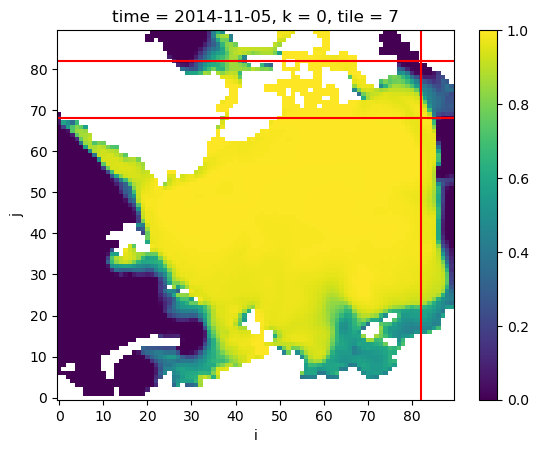

In [44]:
sic_data_2014.isel(tile=6,time=35).plot();
# plt.axvline(x=85,c='r')
# plt.axvline(x=90,c='r')
# plt.axhline(y=71,c='r')
# plt.axhline(y=79,c='r');

plt.axvline(x=82,c='r')
plt.axvline(x=90,c='r')
plt.axhline(y=68,c='r')
plt.axhline(y=82,c='r');

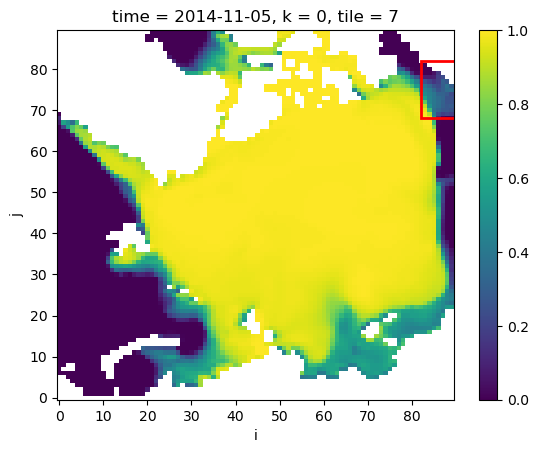

In [45]:
# Plot the data
sic_data_2014.isel(tile=6, time=35).plot()

# Define box parameters
x_start, x_end = 82, 90
y_start, y_end = 68, 82
width = x_end - x_start
height = y_end - y_start

# Add a red rectangle
rect = plt.Rectangle((x_start, y_start), width, height,
                     linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect);

In [8]:
# compute difference
sic_diff_2014 = (sic_data_2014 - sic_cont_2014).isel(k=0,tile=6,i=slice(82,90),j=slice(68,82)).mean(dim=['i','j']) * 100
sic_diff_2015 = (sic_data_2015 - sic_cont_2015).isel(k=0,tile=6,i=slice(82,90),j=slice(68,82)).mean(dim=['i','j']) * 100
sic_diff_2016 = (sic_data_2016 - sic_cont_2016).isel(k=0,tile=6,i=slice(82,90),j=slice(68,82)).mean(dim=['i','j']) * 100
sic_diff_2017 = (sic_data_2017 - sic_cont_2017).isel(k=0,tile=6,i=slice(82,90),j=slice(68,82)).mean(dim=['i','j']) * 100
sic_diff_2018 = (sic_data_2018 - sic_cont_2018).isel(k=0,tile=6,i=slice(82,90),j=slice(68,82)).mean(dim=['i','j']) * 100
sic_diff_2019 = (sic_data_2019 - sic_cont_2019).isel(k=0,tile=6,i=slice(82,90),j=slice(68,82)).mean(dim=['i','j']) * 100

In [9]:
sic_diff_2014 = sic_diff_2014.assign_coords(doy=sic_diff_2014['time'].dt.dayofyear)
sic_diff_2015 = sic_diff_2015.assign_coords(doy=sic_diff_2015['time'].dt.dayofyear)
sic_diff_2016 = sic_diff_2016.assign_coords(doy=sic_diff_2016['time'].dt.dayofyear)
sic_diff_2017 = sic_diff_2017.assign_coords(doy=sic_diff_2017['time'].dt.dayofyear)
sic_diff_2018 = sic_diff_2018.assign_coords(doy=sic_diff_2018['time'].dt.dayofyear)
sic_diff_2019 = sic_diff_2019.assign_coords(doy=sic_diff_2019['time'].dt.dayofyear)

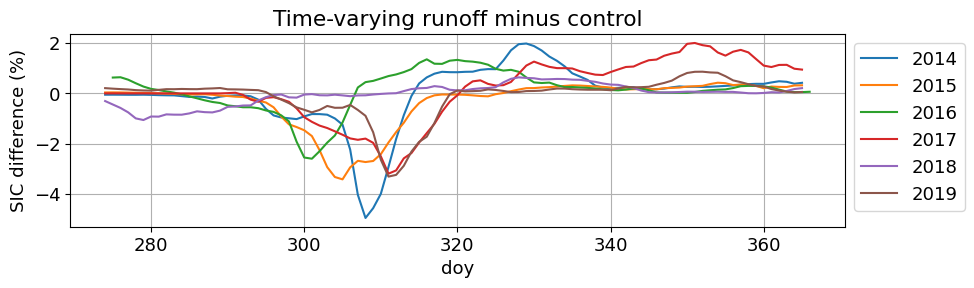

In [17]:
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(1,1,figsize=[10,2.5])

sic_diff_2014.plot(x='doy',ax=ax,label='2014')
sic_diff_2015.plot(x='doy',ax=ax,label='2015')
sic_diff_2016.plot(x='doy',ax=ax,label='2016')
sic_diff_2017.plot(x='doy',ax=ax,label='2017')
sic_diff_2018.plot(x='doy',ax=ax,label='2018')
sic_diff_2019.plot(x='doy',ax=ax,label='2019')

# plt.axhline(y=15,color='k',linewidth=1,linestyle='dashed')
ax.grid()
ax.legend(bbox_to_anchor=[1,1])
# plt.ylim([0,100])
plt.ylabel('SIC difference (%)')
plt.title('Time-varying runoff minus control');

# plt.xlim([np.datetime64('2017-11-01'),np.datetime64('2017-11-13')]);

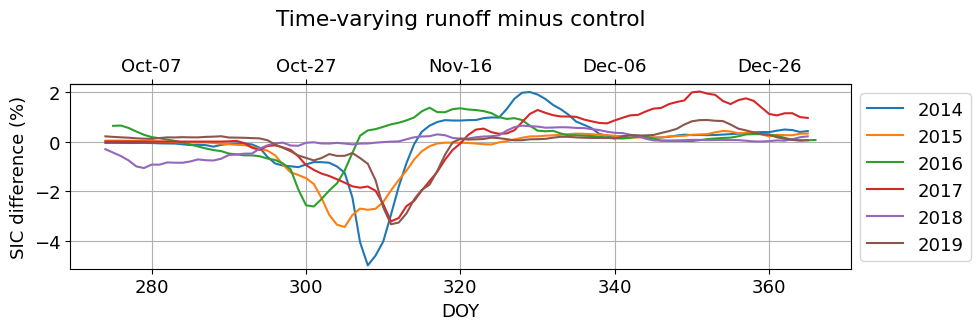

In [18]:
import matplotlib.pyplot as plt
import datetime

plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(1, 1, figsize=[10, 3.5])

# Plot your data
sic_diff_2014.plot(x='doy', ax=ax, label='2014')
sic_diff_2015.plot(x='doy', ax=ax, label='2015')
sic_diff_2016.plot(x='doy', ax=ax, label='2016')
sic_diff_2017.plot(x='doy', ax=ax, label='2017')
sic_diff_2018.plot(x='doy', ax=ax, label='2018')
sic_diff_2019.plot(x='doy', ax=ax, label='2019')

# Grid, legend, and labels
ax.grid()
ax.set_ylim(-5.1,2.3)
ax.set_xlabel('DOY')
ax.legend(bbox_to_anchor=[1, 1])
plt.ylabel('SIC difference (%)')
plt.title('Time-varying runoff minus control\n')

# ---------------------------------------
# Add secondary x-axis: DOY to Mon-Day
# ---------------------------------------

# Use a leap or non-leap year (use 2017 for non-leap)
base_year = 2017

def doy_to_date(doy):
    """Convert day of year to a datetime.date"""
    return (datetime.date(base_year, 1, 1) + datetime.timedelta(doy - 1)).strftime('%b-%d')

# Function to map DOY -> Mon-Day
def forward(x):
    return x

def inverse(x):
    return x

# Add secondary axis
secax = ax.secondary_xaxis('top', functions=(forward, inverse))

# Customize ticks and labels
doy_ticks = [280,300,320,340,360]  # Adjust interval as needed
secax.set_xticks(doy_ticks)
secax.set_xticklabels([doy_to_date(d) for d in doy_ticks])
# secax.set_xlabel('Month-Day')

plt.tight_layout()
plt.show()